# M1969 Tarea 1 implementación mlp 1 capa oculta con backprop

## Alumno: Gerardo de Miguel González

### Descripción

```r
lin<-read.csv(”circle.csv",header = F)
a<-as.matrix(lin[,-3])
b<-as.matrix(lin[,3])
backprop_mlp(a,b, h=5, epochs = 500, eta = 0.1)
# h: hidden neurons
```

**TAREA (los BONUS 1 y 2 son opcionales):**

Generalizar la función `backprop` anterior para que contemple la inclusión de
una capa oculta. Aplicar la función al ejemplo de la clasificación circular.
Si se fija el número máximo de épocas en 1000. ¿Qué número de neuronas
ocultas y qué valor de la tasa de aprendizaje (eta) es óptimo para este
problema? (basta una solución aproximada).

BONUS 1- ¿Sabrías incluir un término de inercia en el método de
backpropagation (ver transparencia 4)?

BONUS 2- Generalizar a un número arbitrario de capas (recomendación,
definir los pesos como una lista de matrices, una para cada capa).

### Dataset Circular

In [30]:
#::GMG::Cargo los datos del problema no lineal (nube de puntos ejemplo)
circle <- read.csv('data/circle.csv', header = F)

In [31]:
#::GMG::Acondiciono el dataset
# https://stackoverflow.com/questions/6081439/changing-column-names-of-a-data-frame
colnames(circle) <- c('x1', 'x2', 'class')
#circle$class <-  as.factor(circle$class)
#levels(circle$class) <- c('outside', 'inside')
str(circle)

'data.frame':	100 obs. of  3 variables:
 $ x1   : num  -0.9719 -0.553 -0.0949 -0.8096 0.399 ...
 $ x2   : num  0.847 -0.577 -0.299 0.857 0.69 ...
 $ class: int  0 0 1 0 0 0 0 0 0 0 ...


In [32]:
#::GMG::la proporción de clases no es muy buena (ojo)
prop.table(x = table(circle$class))


   0    1 
0.71 0.29 

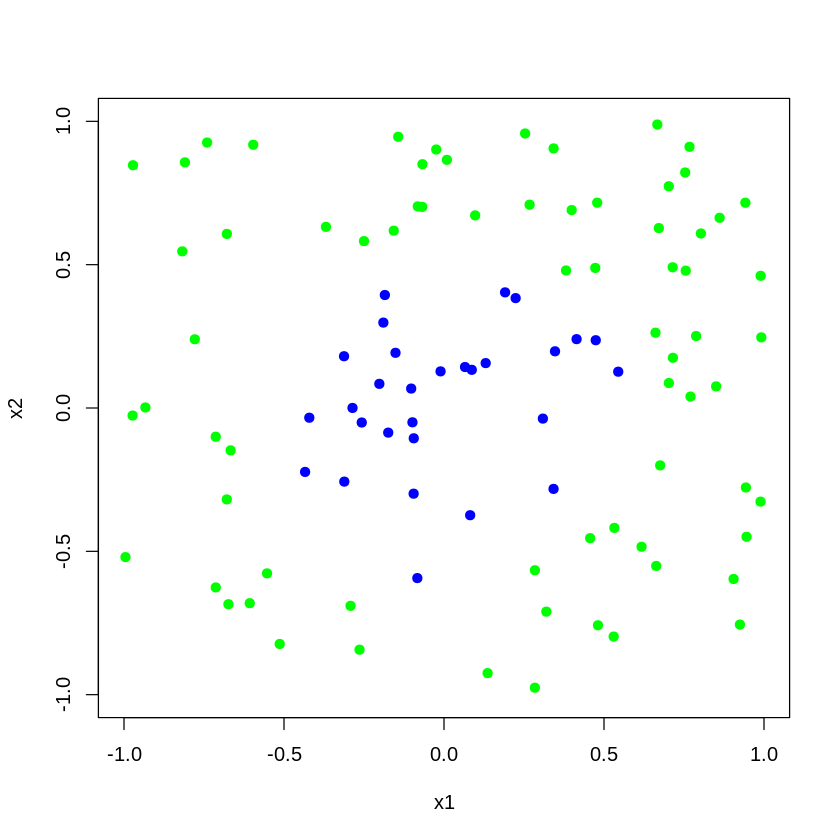

In [33]:
#::GMG::Visualización del dataset circular
ind_c <- which(circle[,'class']==0)
#plot(circle[ind_out,'x1'],circle[ind_out,'x2'],
plot(circle[ind_c,'x1'],circle[ind_c,'x2'],
     type='p',
     xlim=c(-1,1),ylim=c(-1,1), 
     xlab = 'x1', ylab = 'x2',
     col = 'green', pch = 19)
#points(circle[ind_in,'x1'],circle[ind_in,'x2'],
points(circle[-ind_c,'x1'],circle[-ind_c,'x2'],
      col='blue', pch = 19)

### Generalización

In [34]:
#::GMG::Elijo la función de activación que voy a aplicar 
#       a las neuronas ocultas y de salida (S8-S10, S01-Intro-FeedForward.pdf)
#::nota:: f'(x) = f(x) (1 - f(x)) (S10, S01-Intro-FeedForward.pdf)
sigmoid <- function(z) {
    1/(1 + exp(-z))
}

In [35]:
#::GMG::Implemento el paso FeedForward de una red neuronal con UNA capa oculta
#::nota::output -> resultado de la capa de salida 
#        h -> resultado de la capa oculta
#        w1 -> matriz de pesos de entrada a capa oculta
#        w2 -> matriz de pesos de capa oculta a salida
feedforward <- function(x, w1, w2) {
  h <- sigmoid(cbind(1, x) %*% w1)
  o <- sigmoid(cbind(1, h) %*% w2)
  list(output = o, h = h)
}

In [36]:
#::GMG::implemento el algoritmo de aprendizaje backprop con batch gradient descent básico
#::nota::la función de pérdida es la suma de cuadrados (sse)
#::nota::x -> vector (matriz) de muestras de entrada del dataset
#        y -> vector (matriz) de muestras de salida del dataset
#        y_hat -> vector (matriz) de muestras de salida de la red neuronal
#        w1 -> matriz de pesos de entrada a capa oculta
#        w2 -> matriz de pesos de capa oculta a salida
#        h_hat -> vector (matriz) de salida de la capa intermedia
#        learning_rate -> tasa de aprendizaje
backprop <- function(x, y, y_hat, w1, w2, h, learning_rate) {
  error_o <- y - y_hat
  aux_o <- error_o * (y_hat * (1 - y_hat))  
  #::nota::hack drop FALSE para evitar que R convierta la matriz en vector
  # https://www.datamentor.io/r-programming/matrix/
  # ==> NO! error_h <- aux_o%*%t(w2)
  error_h <- aux_o%*%t(w2[-1, , drop = FALSE]) 
  aux_h <- error_h * (h * (1 - h))
  delta_o <- (t(cbind(1,h))%*%aux_o)
  delta_h <- (t(cbind(1,x))%*%aux_h)
  w2 <- w2 + delta_o*learning_rate
  w1 <- w1 + delta_h*learning_rate

  list(w1 = w1, w2 = w2)
}

In [65]:
#::GMG::Implemento la red neuronal mlp (una capa oculta)
#::nota::x -> vector (matriz) de muestras de entrada del dataset
#        y -> vector (matriz) de muestras de salida del dataset
#        h -> número de neuronas en la capa oculta
#        eta -> tasa de aprendizaje
#        x_test -> conjunto de test (opcional)
mi_mlp <- function(y, x, h = 5, epochs = 500, eta = 0.1, x_test = NULL) {

  d <- ncol(x) + 1
  w1 <- matrix(rnorm(d * h), d, h)
  w2 <- matrix(rnorm(h + 1), h + 1, 1)

  for (i in 1:epochs) {
    ff <- feedforward(x, w1, w2)
    bp <- backprop(x, y,
                   y_hat = ff$output,
                   w1, w2,
                   h = ff$h,
                   learning_rate = eta)
    w1 <- bp$w1
    w2 <- bp$w2    
  }
  
  if (is.null(x_test)) {
      test_fitted <- NULL
  } else {
      test_fitted <- feedforward(x_test, w1, w2)$output
  }

  list(fitted = ff$output,
       testFitted = test_fitted,
       w1 = w1, 
       w2 = w2)
}

### Entrenamiento y validación

In [38]:
#::GMG::Voy a usar la biblioteca verification para las métricas
#install.packages('verifiction')
# https://cran.r-project.org/web/packages/verification/verification.pdf
suppressMessages(library('verification'))

In [39]:
#::GMG::Alternativa más interesante
# https://cran.r-project.org/web/packages/MLmetrics/MLmetrics.pdf
#install.packages('MLmetrics')
# The following object is masked from ‘package:base’: Recall
suppressMessages(library('MLmetrics'))

In [40]:
#::GMG::Reproducibilidad
set.seed(1)

In [41]:
#::GMG::Train/Test del dataset
ind <- sort(sample(nrow(circle), nrow(circle)*.8))
circle_train <- circle[ind,]
circle_test <- circle[-ind,]

In [42]:
#::GMG::Mantenemos el desbalance en train y test
prop.table(x = table(circle_train$class))
prop.table(x = table(circle_test$class))


     0      1 
0.7375 0.2625 


  0   1 
0.6 0.4 

In [47]:
#::GMG::Entreno la red neuronal con los hiperparámetros h, epochs y eta
#::nota::incluyo el conjunto de test para hacer la validación del modelo
modelo <- mi_mlp(y = circle_train$class,
                 x = data.matrix(circle_train[, c('x1', 'x2')]), 
                 h = 3, 
                 epochs = 1000, 
                 eta = 0.1,
                 x_test = data.matrix(circle_test[, c('x1', 'x2')])
                )

In [49]:
#::GMG::Obtengo las métricas de la clasificación con la red neuronal
#       Para train
MLmetrics::ConfusionMatrix(y_pred = ifelse(modelo$fitted < 0.5,0,1), 
                           y_true = circle_train[,'class'])

      y_pred
y_true  0  1
     0 59  0
     1  0 21

In [50]:
#::GMG::Para test
MLmetrics::ConfusionMatrix(y_pred = ifelse(modelo$testFitted < 0.5,0,1), 
                           y_true = circle_test[,'class'])

      y_pred
y_true  0  1
     0 12  0
     1  0  8

### Visualización de la separación de clases

In [51]:
#::GMG::uso la biblioteca de gráficos avanzados ggplot
library('ggplot2')

In [52]:
#::GMG::Convierto la clase en un factor
circle$class <-  as.factor(circle$class)
levels(circle$class) <- c('outside', 'inside')
str(circle)

'data.frame':	100 obs. of  3 variables:
 $ x1   : num  -0.9719 -0.553 -0.0949 -0.8096 0.399 ...
 $ x2   : num  0.847 -0.577 -0.299 0.857 0.69 ...
 $ class: Factor w/ 2 levels "outside","inside": 1 1 2 1 1 1 1 1 1 1 ...


In [53]:
#::GMG::creo una malla para el dataset
grid <- expand.grid(x1 = seq(min(circle$x1) - .5,
                             max(circle$x1) + .5,
                             by = .0625),
                    x2 = seq(min(circle$x2) - .5,
                             max(circle$x2) + .5,
                             by = .0625))

In [54]:
#::GMG::Paso el dataset por la red neuronal ya entrenada
ff_grid <- feedforward(x = data.matrix(grid[, c('x1', 'x2')]),
                       w1 = modelo$w1,
                       w2 = modelo$w2)
grid$class <- factor((ff_grid$output > .5) * 1,
                     labels = levels(circle$class))

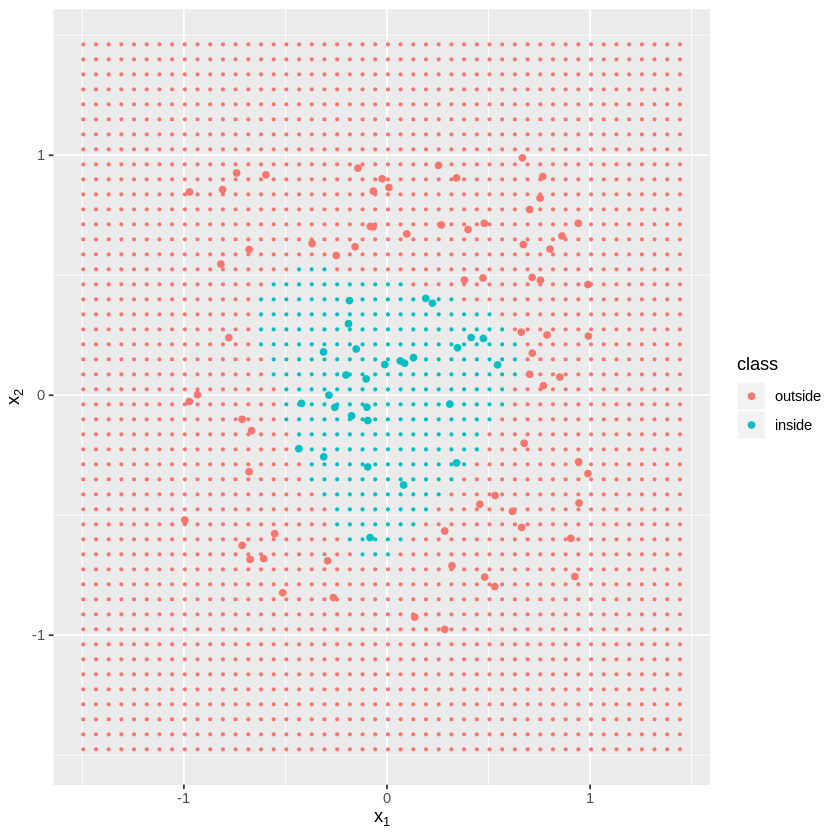

In [55]:
#::GMG::Dibujo el resultado
ggplot(circle) + aes(x1, x2, colour = class) +
  geom_point(data = grid, size = .5) +
  geom_point() +
  labs(x = expression(x[1]), y = expression(x[2]))

### Optimización de hiperparámetros $\eta$ y h

¿Qué número de neuronas ocultas y qué valor de la tasa de aprendizaje (eta) es óptimo para este problema?

#### Neuronas ocultas

In [56]:
#::GMG::Hago una exploración de las neuronas ocultas con la métrica AUC
#       del paquete/biblioteca verification (que se usó en clase)
aucTRAIN <- aucTEST <- vector("numeric", length = 10)
for (i in 1:10) {
  model <- mi_mlp(y = circle_train$class,
                  x = data.matrix(circle_train[, c('x1', 'x2')]), 
                  h = i, 
                  epochs = 1000, 
                  eta = 0.1,
                  x_test = data.matrix(circle_test[, c('x1', 'x2')])
              )
  aucTRAIN[i] <- verification::roc.area(circle_train$class, model$fitted)$A
  aucTEST[i] <- verification::roc.area(circle_test$class, model$testFitted)$A
}

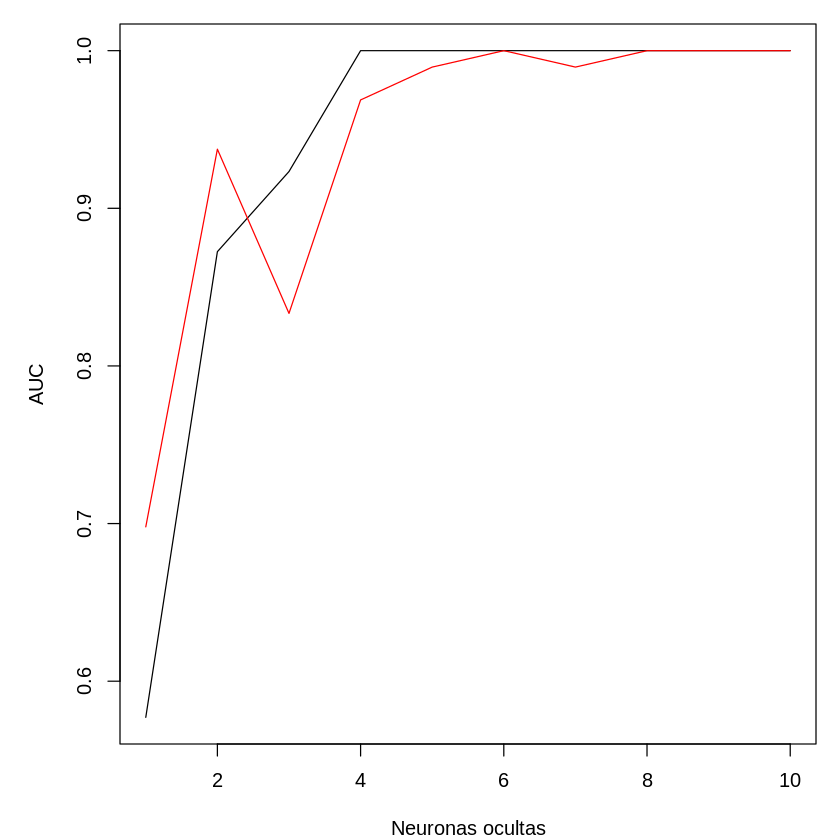

In [57]:
par(mar = c(4,5,1,1))
plot(1:10,aucTRAIN,type = "l", col = "black", ylab = "AUC", xlab = "Neuronas ocultas")
lines(1:10,aucTEST,col = "red")

**::GMG::**: Aquí parece que con 4 neuronas se clasifica el conjunto de train perfectamente con una varianza/sesgo con test baja. Con 6 se tiene una clasificación train/test perfecta. No obstante he visto que con tres en apartados anteriores también he obtenido una clasificación perfecta. Aquí puede que el pequeño tamaño del dataset, la inicialización aleatoria de los parámetros (pesos) y la limitación de épocas estén jugando en la variablidad de los resultados.

#### Tasa de aprendizaje

In [59]:
#::GMG::Pruebo con la tasa de aprendizaje con AUC
aucTRAIN <- aucTEST <- vector("numeric", length = 10)
for (i in 1:10) {
  model <- mi_mlp(y = circle_train$class,
                  x = data.matrix(circle_train[, c('x1', 'x2')]), 
                  h = 4, 
                  epochs = 1000, 
                  eta = i*0.1,
                  x_test = data.matrix(circle_test[, c('x1', 'x2')])
                 )
  aucTRAIN[i] <- verification::roc.area(circle_train$class, model$fitted)$A
  aucTEST[i] <- verification::roc.area(circle_test$class, model$testFitted)$A
}

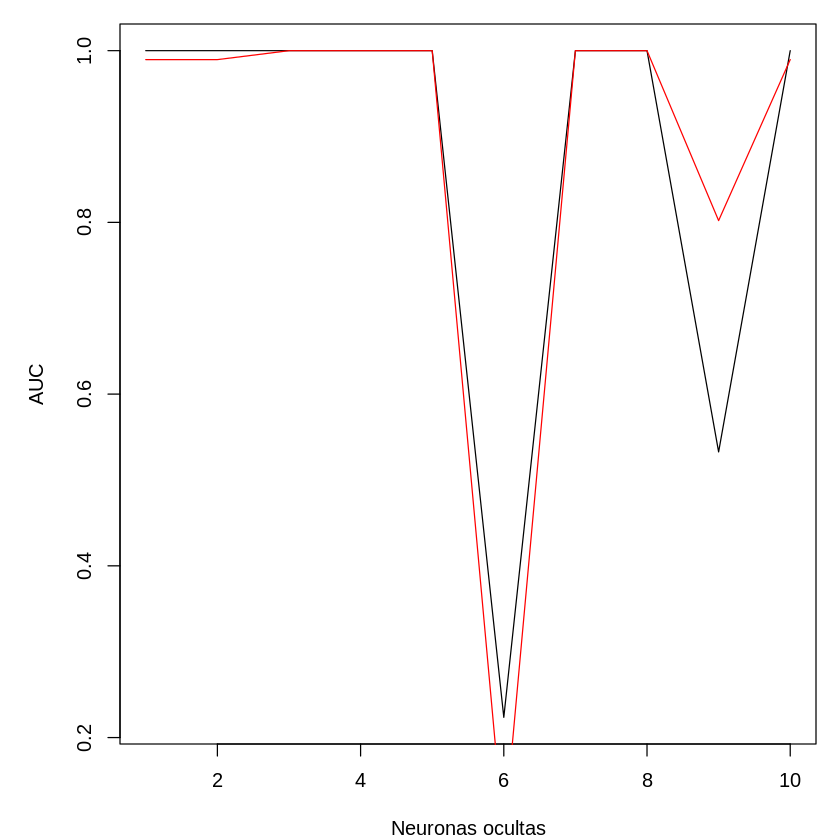

In [60]:
par(mar = c(4,5,1,1))
plot(1:10,aucTRAIN,type = "l", col = "black", ylab = "AUC", xlab = "Neuronas ocultas")
lines(1:10,aucTEST,col = "red")

**::GMG::** Aquí hay una oscilación brutal en cotas superiores a 5 seguramente porque el paso de de descenso de gradiente se dispara y no se converge a un mínimo.

#### Combinación learning rate y neuronas ocultas

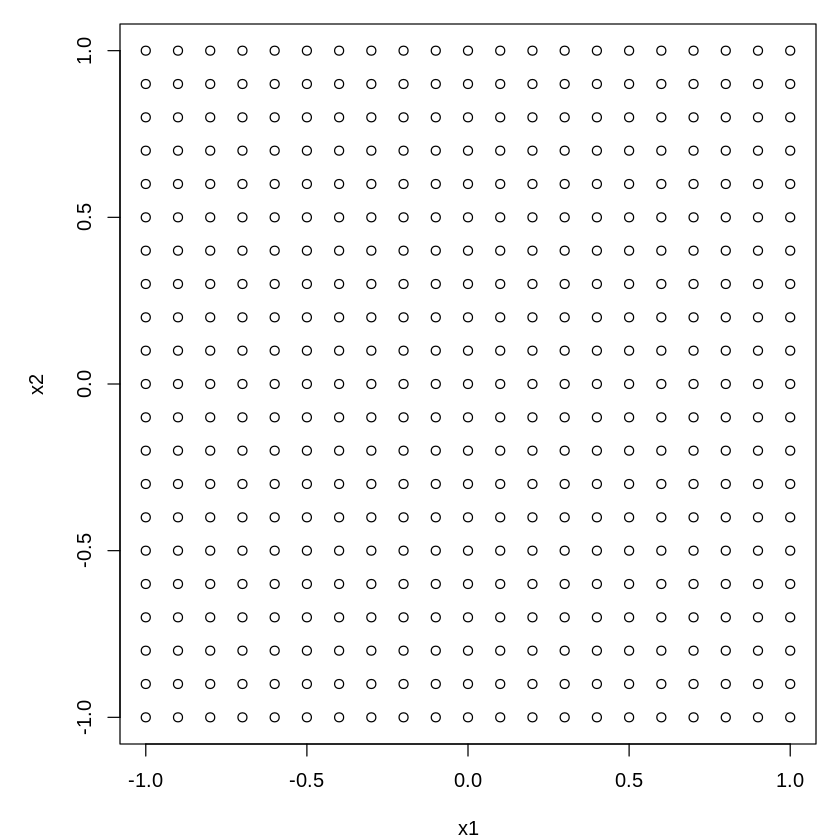

In [61]:
#::GMG::Finalmente hago una exploración grid básica a mano
#::nota::tal y como se ha visto en clase
par(mar = c(4,5,1,1))
x1 <- seq(from = -1, to = 1, by = 0.1)
n <- length(x1)
x1 <- rep(x1,n)
m <- 0
x2 <- vector("numeric", length(x1))
for (i in 1:n) {
  m <- (i-1)*n + 1
  x2[m:(i*n)] <- rep(x1[i],n)
}
plot(x1,x2)

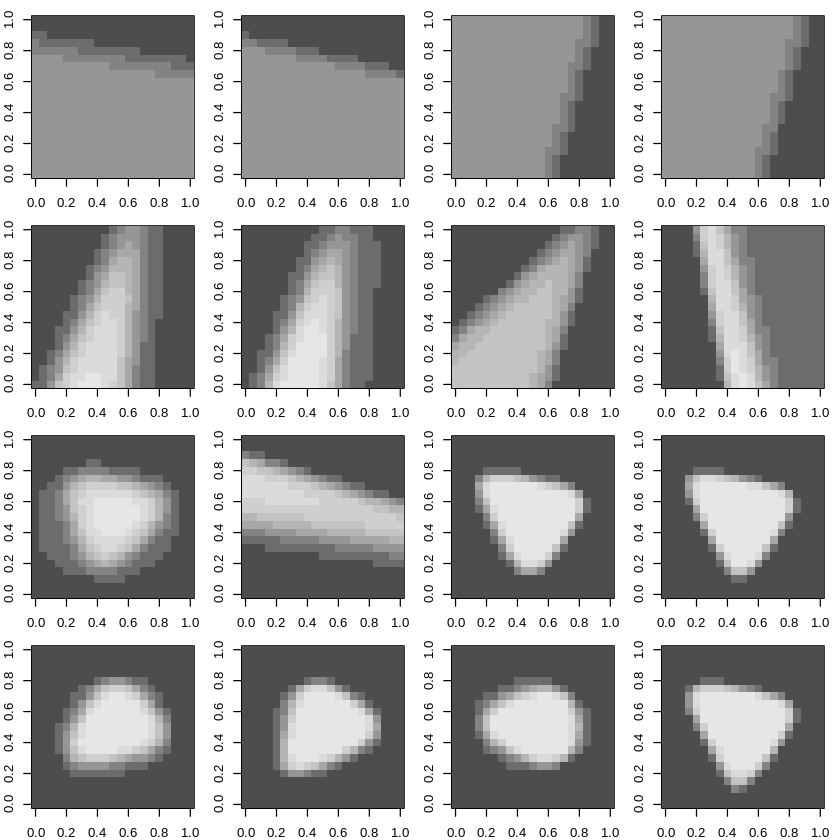

In [79]:
par(mar = c(2,2,1,1), mfrow=c(4,4))
for (j in c(1,2,3,4)){
  for (i in 1:4) {
    model <- mi_mlp(y = circle_train$class,
                    x = data.matrix(circle_train[, c('x1', 'x2')]), 
                    h = j, 
                    epochs = 1000, 
                    eta = i*0.1
                   )
    pred <- feedforward(cbind(x1,x2), model$w1, model$w2)
    image(matrix(pred$output, nrow = n, ncol = n), zlim = c(0,1), col = gray.colors(10)) 
  }
}

**::GMG::** Se puede observar muy bien cómo una o dos neuronas en la capa oculta no son capaces de formar una frontera de decisión no lineal y a partir de 3 se empieza a encontrar la zona que engloba a los puntos "interiores". La tasa de apendizaje bajo no ayuda a encontar el mínimo global con tres neuronas en la capa oculta ni con cuatro (probablemente se necesitarían mñás de 1000 épocas aquí), porque la forma correcta de la región es el triángulo invertido que se ha visto con ggplot. ëste que aparece con tres y cuatro neuronas en la capa oculta y un valor 3,4 veces 0.1 en la tasa de aprendizaje.